# Aiida

## Define workflow with aiida

In [1]:
from python_workflow_definition.aiida import write_workflow_json
from python_workflow_definition.shared import get_dict, get_list

from aiida import load_profile, orm

load_profile()

workflow_json_filename = "aiida_qe.json"

In [2]:
from aiida_workgraph import task, WorkGraph

In [3]:
from quantum_espresso_workflow import generate_structures
from quantum_espresso_workflow import get_bulk_structure
from quantum_espresso_workflow import calculate_qe as _calculate_qe
from quantum_espresso_workflow import plot_energy_volume_curve

In [4]:
calculate_qe = task(outputs=["energy", "volume", "structure"])(_calculate_qe)

In [5]:
wg = WorkGraph("wg-qe")

### Prepare the inputs

In [6]:
element = orm.Str("Al")
a = orm.Float(4.05)
cubic = orm.Bool(True)
relax_workdir = orm.Str("mini")
pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
kpts = orm.List([3, 3, 3])
calc_type_relax = orm.Str("vc-relax")
calc_type_scf = orm.Str("scf")
smearing = orm.Float(0.02)
strain_lst = orm.List([0.9, 0.95, 1.0, 1.05, 1.1])

### Actual tasks to construct the EOS workflow

In [7]:
get_bulk_structure_task = wg.add_task(
    get_bulk_structure,
    name="get_bulk_structure",
    element=element,
    a=a,
    cubic=cubic,
)

In [8]:
relax_prepare_input_dict_task = wg.add_task(
    get_dict,
    name="relax_get_dict",
    structure=get_bulk_structure_task.outputs.result,
    calculation=calc_type_relax,
    kpts=kpts,
    pseudopotentials=pseudopotentials,
    smearing=smearing,
)

relax_task = wg.add_task(
    calculate_qe,
    name="mini",
    input_dict=relax_prepare_input_dict_task.outputs.result,
    working_directory=relax_workdir,
)

In [9]:
generate_structures_task = wg.add_task(
    generate_structures,
    name="generate_structures",
    structure=relax_task.outputs.structure,
    strain_lst=strain_lst,
)

In [10]:
get_volumes_task = wg.add_task(get_list, name="get_volumes")

In [11]:
get_energies_task = wg.add_task(get_list, name="get_energies")

In [12]:
strain_dir_tasks, scf_qe_tasks, scf_get_dict_tasks = [], [], []

for i, strain in enumerate(strain_lst):

    structure_key = f"s_{i}"
    strain_dir = orm.Str(f"strain_{i}")
    generate_structures_task.add_output("workgraph.any", structure_key)

    scf_prepare_input_dict_task = wg.add_task(
        get_dict,
        name=f"get_dict_{i}",
        structure=generate_structures_task.outputs[structure_key],
        calculation=calc_type_scf,
        kpts=kpts,
        pseudopotentials=pseudopotentials,
        smearing=smearing,
    )

    scf_qe_task = wg.add_task(
        calculate_qe,
        name=f"qe_{i}",
        input_dict=scf_prepare_input_dict_task.outputs.result,
        working_directory=strain_dir,
    )

    # collect energy and volume
    get_energies_task.set({f"{i}": scf_qe_task.outputs.energy})
    get_volumes_task.set({f"{i}": scf_qe_task.outputs.volume})

In [13]:
plot_energy_volume_curve_task = wg.add_task(
    plot_energy_volume_curve,
    name="plot_energy_volume_curve",
    volume_lst=get_volumes_task.outputs.result,
    energy_lst=get_energies_task.outputs.result,
)

In [14]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'wg-qe',…

In [15]:
_ = write_workflow_json(wg=wg, file_name=workflow_json_filename)


In [16]:
!cat {workflow_json_filename}

{
  "nodes": {
    "0": "quantum_espresso_workflow.get_bulk_structure",
    "1": "python_workflow_definition.shared.get_dict",
    "2": "quantum_espresso_workflow.calculate_qe",
    "3": "quantum_espresso_workflow.generate_structures",
    "4": "python_workflow_definition.shared.get_list",
    "5": "python_workflow_definition.shared.get_list",
    "6": "python_workflow_definition.shared.get_dict",
    "7": "quantum_espresso_workflow.calculate_qe",
    "8": "python_workflow_definition.shared.get_dict",
    "9": "quantum_espresso_workflow.calculate_qe",
    "10": "python_workflow_definition.shared.get_dict",
    "11": "quantum_espresso_workflow.calculate_qe",
    "12": "python_workflow_definition.shared.get_dict",
    "13": "quantum_espresso_workflow.calculate_qe",
    "14": "python_workflow_definition.shared.get_dict",
    "15": "quantum_espresso_workflow.calculate_qe",
    "16": "quantum_espresso_workflow.plot_energy_volume_curve",
    "17": "Al",
    "18": 4.05,
    "19": true,
    "2

## Load Workflow with jobflow

In [17]:
from python_workflow_definition.jobflow import load_workflow_json

In [18]:
from jobflow.managers.local import run_locally

In [19]:
flow = load_workflow_json(file_name=workflow_json_filename)

2025-04-01 10:50:22,650 INFO Started executing jobs locally
2025-04-01 10:50:22,916 INFO Starting job - get_bulk_structure (cbd7d9e1-e367-4d7c-94f0-310b1a4f9c8f)
2025-04-01 10:50:22,919 INFO Finished job - get_bulk_structure (cbd7d9e1-e367-4d7c-94f0-310b1a4f9c8f)
2025-04-01 10:50:22,920 INFO Starting job - get_dict (5c7d171f-7910-4ce6-9eef-9a4d9a7529a8)
2025-04-01 10:50:22,924 INFO Finished job - get_dict (5c7d171f-7910-4ce6-9eef-9a4d9a7529a8)
2025-04-01 10:50:22,925 INFO Starting job - calculate_qe (8267d4c7-23ef-4ed3-9440-841790f572b7)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-01 10:50:41,470 INFO Finished job - calculate_qe (8267d4c7-23ef-4ed3-9440-841790f572b7)
2025-04-01 10:50:41,471 INFO Starting job - generate_structures (381bd971-0704-48e7-9305-d01622a6847a)
2025-04-01 10:50:41,476 INFO Finished job - generate_structures (381bd971-0704-48e7-9305-d01622a6847a)
2025-04-01 10:50:41,477 INFO Starting job - get_dict (665d2bfd-ff33-4850-a685-935415c3a437)
2025-04-01 10:50:41,479 INFO Finished job - get_dict (665d2bfd-ff33-4850-a685-935415c3a437)
2025-04-01 10:50:41,479 INFO Starting job - get_dict (93373609-fa51-4b84-87ec-bf2bda04050e)
2025-04-01 10:50:41,481 INFO Finished job - get_dict (93373609-fa51-4b84-87ec-bf2bda04050e)
2025-04-01 10:50:41,481 INFO Starting job - get_dict (cd7bcaf9-8078-4f88-b006-e97607f75198)
2025-04-01 10:50:41,483 INFO Finished job - get_dict (cd7bcaf9-8078-4f88-b006-e97607f75198)
2025-04-01 10:50:41,483 INFO Starting job - get_dict (f9f7264c-9233-4f81-8d28-35309b2a030e)
2025-04-01 10:50:41,485 INFO Finished job - get_dict (

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-01 10:50:45,129 INFO Finished job - calculate_qe (da2eec2b-cf50-42a3-9b3f-530ab34f6031)
2025-04-01 10:50:45,130 INFO Starting job - calculate_qe (b1f556b4-d4f1-4c0a-9247-4ec834948138)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-01 10:50:49,010 INFO Finished job - calculate_qe (b1f556b4-d4f1-4c0a-9247-4ec834948138)
2025-04-01 10:50:49,011 INFO Starting job - calculate_qe (427e6966-a3c3-4fb9-8233-2635a5208a3b)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-01 10:50:52,957 INFO Finished job - calculate_qe (427e6966-a3c3-4fb9-8233-2635a5208a3b)
2025-04-01 10:50:52,958 INFO Starting job - calculate_qe (63c1de35-c238-4dcc-8722-3a033abf8cbf)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-01 10:50:57,520 INFO Finished job - calculate_qe (63c1de35-c238-4dcc-8722-3a033abf8cbf)
2025-04-01 10:50:57,521 INFO Starting job - calculate_qe (dee8151b-84fd-473a-8542-d49069bc5981)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-01 10:51:02,340 INFO Finished job - calculate_qe (dee8151b-84fd-473a-8542-d49069bc5981)
2025-04-01 10:51:02,341 INFO Starting job - get_list (19c28499-2069-42a8-8e50-545118a4ecbf)
2025-04-01 10:51:02,345 INFO Finished job - get_list (19c28499-2069-42a8-8e50-545118a4ecbf)
2025-04-01 10:51:02,346 INFO Starting job - get_list (ecbe69ad-c617-41b3-87c8-a25b8b475e10)
2025-04-01 10:51:02,349 INFO Finished job - get_list (ecbe69ad-c617-41b3-87c8-a25b8b475e10)
2025-04-01 10:51:02,349 INFO Starting job - plot_energy_volume_curve (5d6df916-37bb-4dad-aab2-fc9d3733924d)
2025-04-01 10:51:02,420 INFO Finished job - plot_energy_volume_curve (5d6df916-37bb-4dad-aab2-fc9d3733924d)
2025-04-01 10:51:02,421 INFO Finished executing jobs locally


{'cbd7d9e1-e367-4d7c-94f0-310b1a4f9c8f': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structure_features": []}', detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir=PosixPath('/home/wang_x3/repos/superstar54/python-workflow-definition'))},
 '5

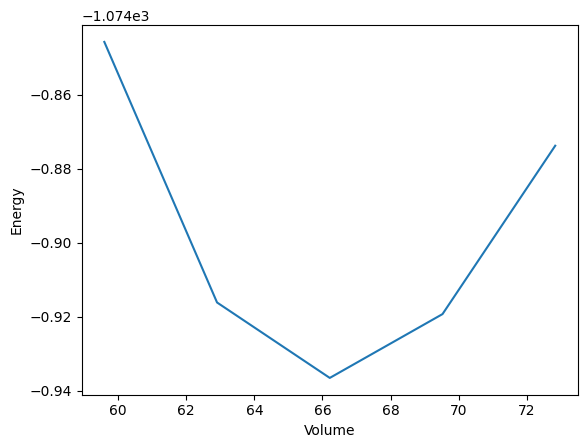

In [20]:
result = run_locally(flow)
result

## Load Workflow with pyiron_base

In [21]:
from pyiron_base import Project

In [22]:
from python_workflow_definition.pyiron_base import load_workflow_json

In [23]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

  0%|          | 0/17 [00:00<?, ?it/s]

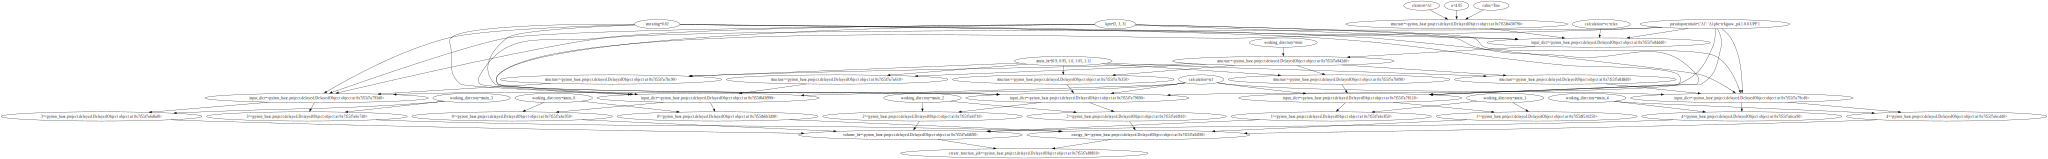

In [24]:
delayed_object = load_workflow_json(project=pr, file_name=workflow_json_filename)
delayed_object.draw()

The job get_bulk_structure_f1e730ed97e30e5439e855d2ac41396f was saved and received the ID: 4
The job get_dict_8c1e72002054a7529280a3e11ba005b5 was saved and received the ID: 5
The job calculate_qe_5e2d55d40f947e1c6791f89f7d93cd7c was saved and received the ID: 6


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_3d675d4377e56d5ea0701d9bc6ca2537 was saved and received the ID: 7
The job get_dict_7395f450ba5bbeb8b3b5f7f04cd1aec9 was saved and received the ID: 8
The job calculate_qe_9b97908b38e6b32fec79d75a790d84c8 was saved and received the ID: 9


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_7dad0bf1f915918f5b44eec63656d045 was saved and received the ID: 10
The job calculate_qe_654811b39aaefd7f278e1e4d074d8e8a was saved and received the ID: 11


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_dc6498824bbcffe1870502beda1e99ce was saved and received the ID: 12
The job calculate_qe_0bc9039e5d46cf41c8a5f8bddf5445dc was saved and received the ID: 13


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_c9b3348d986cce1499e3c6382b6af93e was saved and received the ID: 14
The job calculate_qe_259189d1dff5a59e2e8184e71d9597d7 was saved and received the ID: 15


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_3c8d628835f56af4881e577db8c861ab was saved and received the ID: 16
The job calculate_qe_f998ab33e0425ea3403460a5d2b17552 was saved and received the ID: 17


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_2e2c8977ec516980a06d35fe27dacb7e was saved and received the ID: 18
The job get_list_a67fcac31c6773ce51be0e8903d33c68 was saved and received the ID: 19
The job plot_energy_volume_curve_c282015f1c661a67154d2e1f50e9c167 was saved and received the ID: 20


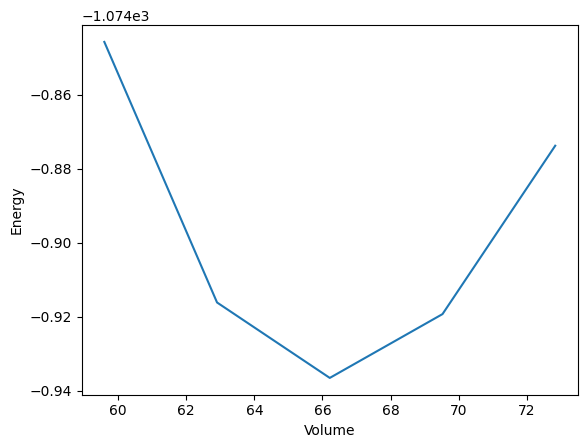

In [25]:
delayed_object.pull()